In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier

In [164]:
import distribution_modules as dm
import density_estimation_modules as dem
import importlib

importlib.reload(dm)
importlib.reload(dem)

<module 'density_estimation_modules' from 'C:\\Users\\shfar\\Desktop\\SU\\Thesis\\thesis\\density_estimation_modules.py'>

In [165]:
bounded_dists = dm.get_bounded_distribution()
bounded_dists

{'arcsine': <scipy.stats._distn_infrastructure.rv_frozen at 0x28ee2295f40>,
 'beta_1_2': <scipy.stats._distn_infrastructure.rv_frozen at 0x28ee21cc3d0>,
 'powerlaw_0.3': <scipy.stats._distn_infrastructure.rv_frozen at 0x28ee28f96d0>,
 'trapezoid_0.3_0.8': <scipy.stats._distn_infrastructure.rv_frozen at 0x28ee21cc580>,
 'traing_0.3': <scipy.stats._distn_infrastructure.rv_frozen at 0x28ee21bd1c0>,
 'uniform': <scipy.stats._distn_infrastructure.rv_frozen at 0x28ee21bd9a0>}

In [166]:
# set configurations for number of samples and moments
s_size = 500
nr_sample = 20
x = np.linspace(0,1,10)

In [167]:
kde_df = dem.get_kde(bounded_dists, nr_sample, s_size, x)
kde_df.head()

,0,1,2,3,4,5,6,7,8,9,dist
0,0.916544,1.050745,0.819521,0.652317,0.639844,0.721324,0.743977,0.827170,1.051907,0.851083,arcsine
1,0.931997,1.136721,0.923491,0.701273,0.568638,0.527061,0.618318,0.841344,1.067043,0.886817,arcsine
2,0.856801,1.102027,0.891634,0.690130,0.618604,0.594511,0.665190,0.825394,1.069321,0.937792,arcsine
3,0.919727,1.061179,0.776535,0.595022,0.588201,0.641834,0.714215,0.869768,1.098880,0.927540,arcsine
4,0.992079,1.182660,0.902014,0.683482,0.651939,0.687537,0.720778,0.803438,0.924156,0.737331,arcsine


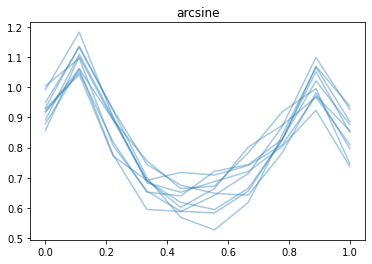

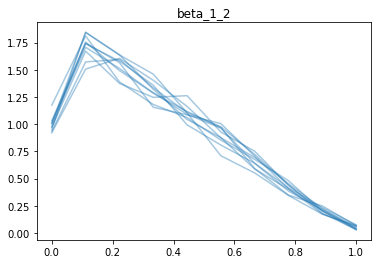

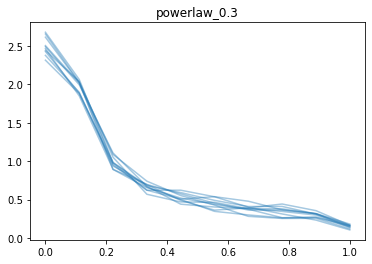

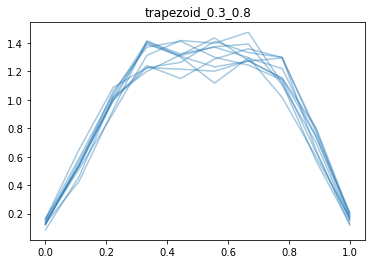

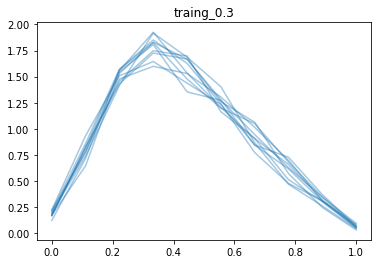

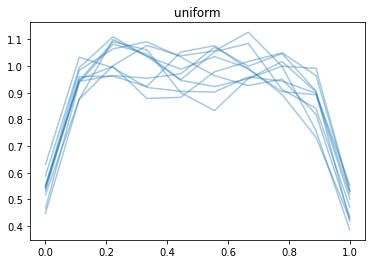

In [168]:
dem.get_kde_plot(bounded_dists, kde_df, nr_sample, s_size, x)

In [115]:
def prepare_data(df, test_size):
    X = df.drop('dist', axis=1)
    y = df['dist']
    
    # Scaling data
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = test_size, random_state=11)
    return X, y, X_train, X_test, y_train, y_test

In [163]:
def svm_model(X, y, X_train, X_test, y_train, y_test, cv):
    param_grid = [
        {'C':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
         'gamma':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10], 
         'kernel':['rbf']},
    ]

    optimal_params = GridSearchCV(SVC(), param_grid,cv=5, verbose=0)
    optimal_params.fit(X_train, y_train)

    clf_svm = SVC(random_state=10, C=optimal_params.best_params_['C'], gamma=optimal_params.best_params_['gamma'])
    clf_svm.fit(X_train, y_train)

    y_pred = clf_svm.predict(X_test)
    scores = cross_val_score(clf_svm, X, y, cv=cv)
    accuracy = scores.mean()
    
    return y_pred, accuracy, scores

In [162]:
X, y, X_train, X_test, y_train, y_test = prepare_data(kde_df, 0.2)
svm_model(X, y, X_train, X_test, y_train, y_test, 5)

(array(['traing_0.3', 'arcsine', 'uniform', 'traing_0.3', 'arcsine',
        'trapezoid_0.3_0.8', 'arcsine', 'arcsine', 'powerlaw_0.3',
        'beta_1_2', 'arcsine', 'beta_1_2', 'beta_1_2', 'trapezoid_0.3_0.8',
        'traing_0.3', 'trapezoid_0.3_0.8', 'traing_0.3', 'uniform',
        'traing_0.3', 'powerlaw_0.3', 'beta_1_2', 'arcsine',
        'trapezoid_0.3_0.8', 'trapezoid_0.3_0.8'], dtype=object),
 1.0,
 array([1., 1., 1., 1., 1.]))

In [109]:
np.linspace(0,1,10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

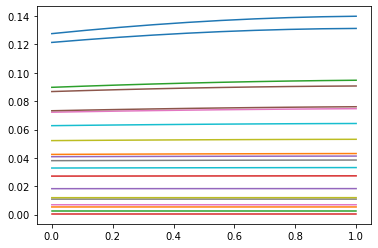

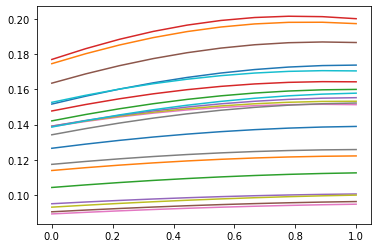

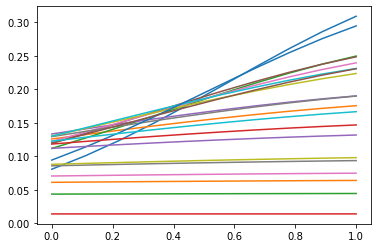

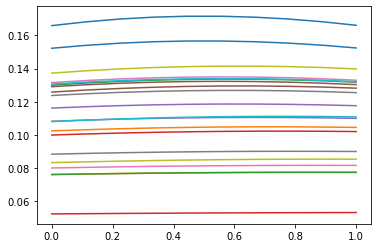

In [121]:
longtail_dists = dm.get_longtail_distribution()

x = np.linspace(0,1,10)
kde_df = dem.get_kde(longtail_dists, nr_sample, s_size, x)
for name,distr in (longtail_dists.items()):
    fig, ax = plt.subplots()
    temp = kde_df.loc[kde_df['dist']==name]
    for i in range(20):
        y = temp.iloc[i]
        dist_name = y[-1:][0]
        y = y[:-1]

        ax.plot(x,y)  

In [145]:
longtail_dists

{'cauchy': <scipy.stats._distn_infrastructure.rv_frozen at 0x28ee3c2a760>,
 'lognorm_1.5': <scipy.stats._distn_infrastructure.rv_frozen at 0x28ee3c2aa30>,
 'pareto_1.5': <scipy.stats._distn_infrastructure.rv_frozen at 0x28ee3c2aa60>,
 'weibull_min_0.4': <scipy.stats._distn_infrastructure.rv_frozen at 0x28ee3c2afa0>}

In [120]:
kde_df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,dist
0,0.127659,0.127878,0.128095,0.128311,0.128525,0.128737,0.128947,0.129155,0.129362,0.129567,...,0.139693,0.139730,0.139764,0.139797,0.139827,0.139855,0.139881,0.139905,0.139927,cauchy
1,0.042466,0.042475,0.042484,0.042493,0.042501,0.042510,0.042519,0.042527,0.042536,0.042544,...,0.043054,0.043058,0.043062,0.043066,0.043070,0.043073,0.043077,0.043080,0.043084,cauchy
2,0.089789,0.089869,0.089949,0.090029,0.090107,0.090185,0.090263,0.090340,0.090416,0.090492,...,0.094613,0.094637,0.094660,0.094683,0.094704,0.094725,0.094746,0.094766,0.094785,cauchy
3,0.000493,0.000493,0.000493,0.000493,0.000493,0.000493,0.000493,0.000493,0.000493,0.000493,...,0.000493,0.000493,0.000493,0.000493,0.000493,0.000493,0.000493,0.000493,0.000493,cauchy
4,0.040845,0.040852,0.040859,0.040866,0.040873,0.040879,0.040886,0.040893,0.040899,0.040906,...,0.041274,0.041276,0.041278,0.041281,0.041283,0.041285,0.041288,0.041290,0.041292,cauchy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.125839,0.125957,0.126073,0.126187,0.126300,0.126410,0.126519,0.126626,0.126731,0.126834,...,0.128700,0.128643,0.128585,0.128524,0.128462,0.128397,0.128331,0.128264,0.128194,weibull_min_0.4
76,0.080150,0.080186,0.080222,0.080258,0.080292,0.080327,0.080361,0.080395,0.080428,0.080461,...,0.081733,0.081731,0.081729,0.081726,0.081723,0.081719,0.081715,0.081710,0.081705,weibull_min_0.4
77,0.088466,0.088509,0.088553,0.088596,0.088638,0.088680,0.088721,0.088761,0.088801,0.088841,...,0.090158,0.090151,0.090143,0.090134,0.090125,0.090115,0.090105,0.090094,0.090082,weibull_min_0.4
78,0.083384,0.083430,0.083475,0.083520,0.083564,0.083608,0.083651,0.083694,0.083736,0.083778,...,0.085494,0.085494,0.085493,0.085492,0.085490,0.085488,0.085485,0.085482,0.085478,weibull_min_0.4


In [148]:
# old version
from sklearn.neighbors import KernelDensity

def get_kde_estimates(distributions_dict, nr_sample, sample_size, x_values, bandwidth):
    df = pd.DataFrame()
    for i, (name, distr) in enumerate(distributions_dict.items()):
        y_estimates = list()
        samples = distr.rvs(size=(nr_sample, sample_size), random_state=10)

        for j in range(nr_sample):
            X = samples[j,:]
            X = X.reshape((len(X),1))

            kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X)

            values = np.linspace(0,1,x_values)
            values = values.reshape((len(values),1))

            log_density = kde.score_samples(values)
            y_estimates.append(np.exp(log_density))

        df_per_dist = pd.DataFrame(y_estimates)  
        df_per_dist['dist'] = name

        df = pd.concat([df,df_per_dist], ignore_index=True)

    return df 

In [149]:
kde_df = get_kde_estimates(longtail_dists, 20, 500, 100, 0.05)
kde_df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,dist
0,0.361868,0.423374,0.482420,0.536306,0.582847,0.620638,0.649177,0.668847,0.680741,0.686396,...,0.269599,0.263813,0.261448,0.263027,0.268883,0.279032,0.293051,0.310018,0.328557,cauchy
1,0.407846,0.457829,0.500163,0.533389,0.557311,0.572949,0.582240,0.587560,0.591192,0.594882,...,0.314978,0.319110,0.320835,0.319562,0.315100,0.307649,0.297710,0.285966,0.273155,cauchy
2,0.319407,0.361173,0.397911,0.427955,0.450322,0.464827,0.472105,0.473528,0.471038,0.466915,...,0.393886,0.398473,0.400200,0.398309,0.392519,0.383068,0.370631,0.356133,0.340510,cauchy
3,0.377713,0.432120,0.481059,0.522165,0.553887,0.575678,0.588032,0.592374,0.590840,0.585979,...,0.270874,0.273323,0.278641,0.285938,0.294214,0.302533,0.310186,0.316782,0.322259,cauchy
4,0.392480,0.452544,0.510791,0.565535,0.615362,0.659120,0.695886,0.724927,0.745701,0.757896,...,0.361091,0.365086,0.367751,0.368058,0.365375,0.359558,0.350941,0.340227,0.328329,cauchy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2.108098,2.239863,2.311957,2.324093,2.282120,2.196497,2.080102,1.945912,1.805080,1.665746,...,0.176650,0.179879,0.182093,0.183086,0.182804,0.181331,0.178840,0.175544,0.171660,weibull_min_0.4
76,2.246153,2.356014,2.395142,2.365315,2.275620,2.140464,1.976811,1.801312,1.627955,1.466646,...,0.192688,0.192340,0.193777,0.197046,0.202008,0.208344,0.215581,0.223124,0.230279,weibull_min_0.4
77,2.135856,2.248837,2.296534,2.280118,2.207587,2.092005,1.948987,1.794049,1.640395,1.497534,...,0.065418,0.063941,0.062562,0.061429,0.060639,0.060229,0.060201,0.060544,0.061268,weibull_min_0.4
78,1.972357,2.088326,2.145937,2.144758,2.090272,1.992565,1.864400,1.719144,1.569013,1.423874,...,0.128423,0.130877,0.132942,0.134589,0.135948,0.137295,0.138999,0.141415,0.144782,weibull_min_0.4


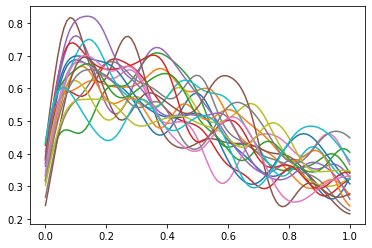

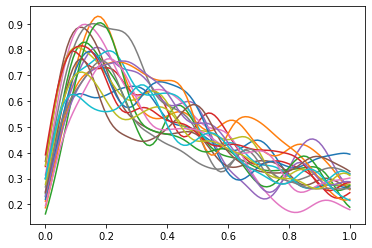

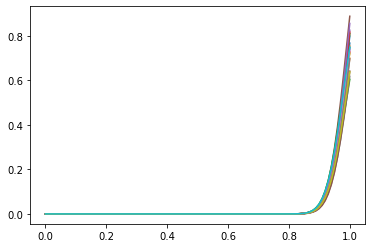

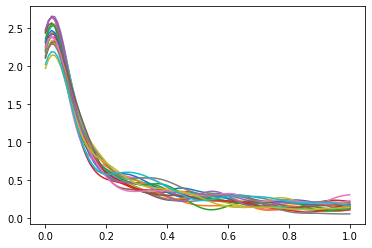

In [150]:
for name,distr in (longtail_dists.items()):
    fig, ax = plt.subplots()
    temp = kde_df.loc[kde_df['dist']==name]
    for i in range(20):
        y = temp.iloc[i]
        dist_name = y[-1:][0]
        y = y[:-1]
        x = np.linspace(0,1,100)
        ax.plot(x,y)  

In [179]:
X, y, X_train, X_test, y_train, y_test = prepare_data(kde_df, 0.2)
svm_model(X, y, X_train, X_test, y_train, y_test, 5)

(array(['cauchy', 'cauchy', 'pareto_1.5', 'pareto_1.5', 'weibull_min_0.4',
        'weibull_min_0.4', 'weibull_min_0.4', 'lognorm_1.5', 'cauchy',
        'cauchy', 'cauchy', 'cauchy', 'weibull_min_0.4', 'lognorm_1.5',
        'weibull_min_0.4', 'pareto_1.5'], dtype=object),
 0.9125,
 array([0.9375, 0.9375, 1.    , 0.8125, 0.875 ]))